# **The Grand Cycle – Autonomous Logic Tuning**
### ***Automating Semantic Grounding and Rule Strength with Optuna***

In Neuro-Symbolic AI, the bridge between raw data and logic is called **Grounding**. In previous tutorials, we manually defined "High Alcohol" or "Low Acidity." However, finding the exact point where a value becomes "logically true" is often the hardest part of model design.

This **"Grand Cycle"** represents a self-optimizing loop that automates the discovery of:
1. **Semantic Boundaries:** Finding the optimal `center` and `steepness` for fuzzy predicates.
2. **Logical Integrity:** Balancing accuracy with the `contradiction_penalty` to ensure the model remains logically consistent ($L \leq U$).
3. **Hyper-Parameters:** Optimizing the `learning_rate` and `rule_strength` using an automated search space.

By the end of this tutorial, the system will not only provide a trained model but also a **symbolic report** that can be interpreted by a human or an LLM agent for further iterations.

## ***1. Installation and automatic restart***
In Google Colab, you just need to install the package directly from GitHub. Since the export tools are built-in, no extra parameters are needed

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import optuna
    import matplotlib.pyplot as plt
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install optuna optuna-dashboard pandas scikit-learn matplotlib
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    !pip install  scikit-learn pandas

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take in

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
!rm -rf /content/sample_data

### ***Library imports***

In [3]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from jlnn.symbolic.compiler import LNNFormula
from jlnn.utils.xarray_utils import model_to_xarray, extract_weights_to_xarray
from jlnn.training.losses import total_lnn_loss

## ***2. Dataset – Wine Quality (red)***

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")

In [5]:
df["good"] = (df["quality"] >= 7).astype(int)

We select 4 key symptoms (can be expanded to all 11)

In [6]:
features = ["alcohol", "volatile acidity", "sulphates", "chlorides"]
X = df[features].values
y = df["good"].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [8]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm  = scaler.transform(X_test)

## ***3. Fuzzy grounding***

In [9]:
def fuzzy_ramp(x, center, steepness):
    return 1 / (1 + jnp.exp(-steepness * (x - center)))

In [10]:
def create_inputs(X_norm, p):
    high_alcohol   = fuzzy_ramp(X_norm[:, 0], p["c_alcohol"],   p["steepness"])
    low_acidity    = 1 - fuzzy_ramp(X_norm[:, 1], p["c_acidity"],   p["steepness"])
    high_sulphates = fuzzy_ramp(X_norm[:, 2], p["c_sulphates"], p["steepness"])
    low_chlorides  = 1 - fuzzy_ramp(X_norm[:, 3], p["c_chlorides"], p["steepness"])

    # For JLNN – shape (batch, n_literals, 2) for [L,U], here simple [val, val+epsilon]
    epsilon = 0.05
    inputs = {
        "high_alcohol":   jnp.stack([high_alcohol, high_alcohol + epsilon], axis=-1),
        "low_acidity":    jnp.stack([low_acidity,  low_acidity  + epsilon], axis=-1),
        "high_sulphates": jnp.stack([high_sulphates, high_sulphates + epsilon], axis=-1),
        "low_chlorides":  jnp.stack([low_chlorides,  low_chlorides  + epsilon], axis=-1)
    }

    return inputs

## ***4. Objective function for Optuna***

The `objective` function acts as an automated scientist. In each trial, it:
* **Suggests:** Picks a combination of fuzzy boundaries and training parameters.
* **Grounds:** Transforms raw Wine Quality data into logical truth values.
* **Trains:** Executes a JLNN training session using `optax` with a Warmup Cosine Schedule.
* **Evaluates:** Measures performance on a validation set to guide the next "guess."

In [11]:
def objective(trial):
    # Hyperparameters to tune
    p = {
        "lr_peak":       trial.suggest_float("lr_peak", 1e-4, 5e-2, log=True),
        "steepness":     trial.suggest_float("steepness", 6.0, 18.0),
        "c_alcohol":     trial.suggest_float("c_alcohol", 0.40, 0.80),
        "c_acidity":     trial.suggest_float("c_acidity", 0.10, 0.45),
        "c_sulphates":   trial.suggest_float("c_sulphates", 0.40, 0.80),
        "c_chlorides":   trial.suggest_float("c_chlorides", 0.05, 0.30),
        "rule_strength": trial.suggest_float("rule_strength", 0.85, 1.00),
        "contra_p":      trial.suggest_float("contra_p", 0.5, 5.0),
    }

    # ─── Creating a model ────────────────────────────────────────────────────
    rule = f"{p['rule_strength']:.3f} :: (high_alcohol & low_acidity & high_sulphates & low_chlorides)"
    model = LNNFormula(rule, nnx.Rngs(42))

    # ─── Optimizer ───────────────────────────────────────────────────────────
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=p["lr_peak"],
        warmup_steps=300,
        decay_steps=8000,
        end_value=1e-6
    )
    tx = optax.adamw(schedule, weight_decay=1e-5)
    optimizer = nnx.Optimizer(model, tx, wrt=nnx.Param)

    # ─── Training ─────────────────────────────────────────────────────────────
    train_inputs = create_inputs(X_train_norm, p)
    target_interval = jnp.where(
        y_train[:, None] == 1,
        jnp.array([[0.85, 1.00]]),
        jnp.array([[0.00, 0.15]])
    )

    best_test_acc = 0.0
    for step in range(3001):

        pred = model(train_inputs)                     # (batch, 4, 2)
        pred_agg = jnp.min(pred, axis=1)               # conservative AND → (batch, 2)
        # or
        # pred_agg = jnp.max(pred, axis=1)             # optimistic
        # pred_agg = jnp.mean(pred, axis=1)            # mean

        mse = jnp.mean((pred_agg - target_interval)**2)
        # or if you have total_lnn_loss which expects (batch, 2):
        loss = total_lnn_loss(pred_agg, target_interval, contradiction_weight=p["contra_p"])

        if step % 1000 == 0:
            test_inputs = create_inputs(X_test_norm, p)
            preds = model(test_inputs)                     # forward pass without grads is the default
            preds_agg = jnp.min(preds, axis=1)             # or max/mean
            test_acc = jnp.mean((preds_agg[:, 0] > 0.5) == y_test)
            if test_acc > best_test_acc:
                best_test_acc = test_acc

    return best_test_acc

## ***5. Launching the study***

In [12]:
study = optuna.create_study(direction="maximize", study_name="JLNN_Wine_Grand_Cycle")
study.optimize(objective, n_trials=35, timeout=2400)  # ~40 min max

[I 2026-02-19 23:42:48,961] A new study created in memory with name: JLNN_Wine_Grand_Cycle
[I 2026-02-19 23:43:42,950] Trial 0 finished with value: 0.8549999594688416 and parameters: {'lr_peak': 0.003984522108137497, 'steepness': 15.82834652388598, 'c_alcohol': 0.4189523341321784, 'c_acidity': 0.3494831835667894, 'c_sulphates': 0.4576499200880467, 'c_chlorides': 0.06313365971225736, 'rule_strength': 0.8908933000651438, 'contra_p': 4.3410752812956}. Best is trial 0 with value: 0.8549999594688416.
[I 2026-02-19 23:44:25,711] Trial 1 finished with value: 0.8524999618530273 and parameters: {'lr_peak': 0.00021519050928604235, 'steepness': 8.51938799850744, 'c_alcohol': 0.6602382508790531, 'c_acidity': 0.2496904084231292, 'c_sulphates': 0.759416735657136, 'c_chlorides': 0.21955289090102653, 'rule_strength': 0.8964261786124188, 'contra_p': 4.184841777491876}. Best is trial 0 with value: 0.8549999594688416.
[I 2026-02-19 23:45:08,618] Trial 2 finished with value: 0.8624999523162842 and paramet

## ***6. Results + visualization***


Best trial: #27
Best accuracy test: 0.8925
Best parameters:
  lr_peak           : 0.0177
  steepness         : 7.1186
  c_alcohol         : 0.5857
  c_acidity         : 0.1335
  c_sulphates       : 0.5897
  c_chlorides       : 0.1169
  rule_strength     : 0.9175
  contra_p          : 1.9514


/tmp/ipython-input-2631531988.py:10: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


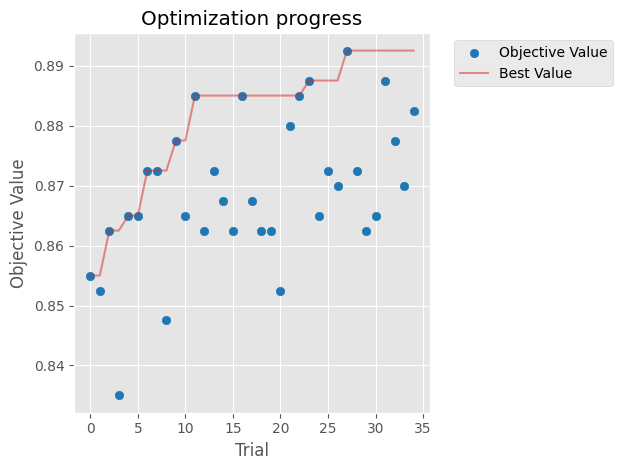

/tmp/ipython-input-2631531988.py:14: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


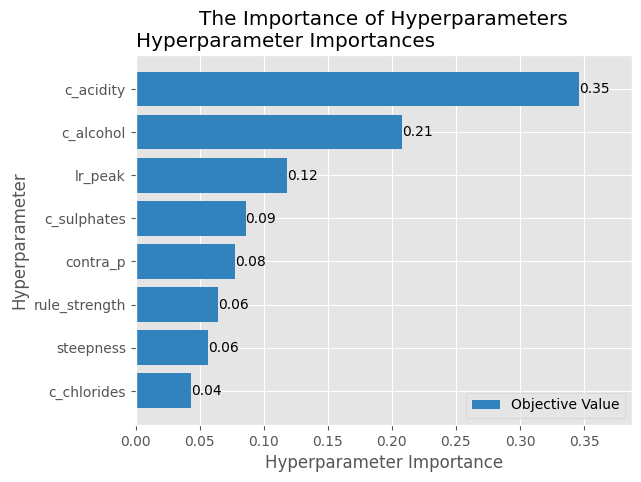

/tmp/ipython-input-2631531988.py:18: ExperimentalWarning: optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["steepness", "rule_strength"])


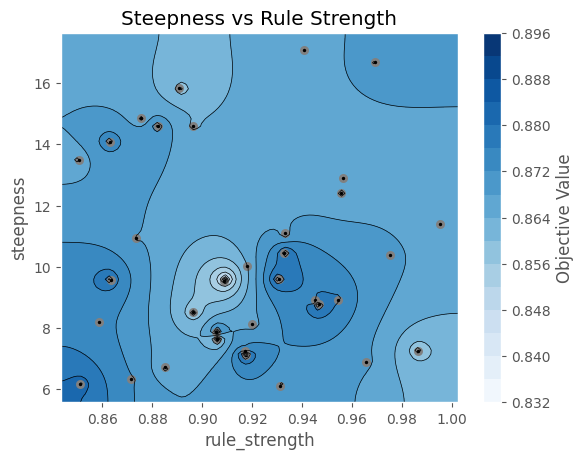

In [13]:
print("\n" + "="*80)
print(f"Best trial: #{study.best_trial.number}")
print(f"Best accuracy test: {study.best_value:.4f}")
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"  {k:18}: {v:.4f}")
print("="*80)

# Charts
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization progress")
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("The Importance of Hyperparameters\n")
plt.show()

optuna.visualization.matplotlib.plot_contour(study, params=["steepness", "rule_strength"])
plt.title("Steepness vs Rule Strength")
plt.show()

## ***7. Report for another LLM agent***

The final report generated at the end of this notebook is formatted for **LLM consumption** (e.g., Gemma 3, Llama 3). This creates a feedback loop where an AI Agent can look at the Optuna results and the Decision Tree analysis to propose new logical rules or adjust the search space for the next "Grand Cycle."

In [14]:
report = f"""
Best achieved test accuracy: {study.best_value:.4f}

Best configuration:
{study.best_params}

Recommendations for the next iteration:
- Increase the steepness to {study.best_params['steepness'] + 2:.1f}–{study.best_params['steepness'] + 6:.1f}
- Keep rule_strength close {study.best_params['rule_strength']:.3f}
- Reduce contradiction penalties under {study.best_params['contra_p']:.1f} if the intervals become too narrow

Next step: try adding another flag (e.g. 'citric acid') and running Grand Cycle again.
"""

print("\n" + "="*80)
print("REPORT FOR LLM AGENT / NEXT ITERATION")
print("="*80)
print(report)


REPORT FOR LLM AGENT / NEXT ITERATION

Best achieved test accuracy: 0.8925

Best configuration:
{'lr_peak': 0.017678471547690457, 'steepness': 7.118590482196106, 'c_alcohol': 0.5856649050434947, 'c_acidity': 0.13351673731842792, 'c_sulphates': 0.5897323769821371, 'c_chlorides': 0.1169293713996371, 'rule_strength': 0.9175494112213427, 'contra_p': 1.951417055336893}

Recommendations for the next iteration:
- Increase the steepness to 9.1–13.1
- Keep rule_strength close 0.918
- Reduce contradiction penalties under 2.0 if the intervals become too narrow

Next step: try adding another flag (e.g. 'citric acid') and running Grand Cycle again.

